In [12]:
import sys
import yaml
sys.path.append('../')
import os
import torch
from misc import yaml_util as yu
sys.path.append('../dataset')
sys.path.append('../module')
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from misc import character_analysis as ca


In [13]:
datname = 'OneDsignal_c8mimic'
#datname = 'OneDCyclic'
modelname = 'fordebug'
#modelname = 'mask2Stacklayer'
#modelname = 'mlp1layer_nonDim'
#modelname = 'mask1layer'

trainname = 'baseline'
with open(f'''../cfg_data/{datname}.yaml''', 'rb') as f:
    cfg_data = yaml.safe_load(f)

cfg_data['args']['shift_label'] = True
mydata = yu.load_component(cfg_data) 

myloader = DataLoader(mydata, batch_size=20,
                        shuffle=True, 
                        num_workers=1,
                        )


seq, shift =  mydata[0]
seq = seq[None, :]
print(seq.shape)

expname = f'''{datname}_{modelname}_{trainname}'''

exppath = os.path.join("../dnftresult", expname)
if not os.path.exists(exppath):
    raise NotImplementedError
mymodelpath = f"""{exppath}/model.pt"""
mymodel = torch.load(mymodelpath)
mymodel = mymodel.to(0)
mymodel

./dataset/oneDsignal_data.py
[0, 2, 10, 16, 23, 7]
0
torch.Size([1, 3, 128])


DFNFT(
  (owndecoders): ModuleList(
    (0): MLPDecoder(
      (activation_fxn): Identity()
      (net): Sequential(
        (0): MaskFlatLinear()
        (1): Linear(in_features=132, out_features=128, bias=True)
      )
    )
    (1): MLPDecoder(
      (activation_fxn): Tanh()
      (net): Sequential(
        (0): MaskFlatLinear()
      )
    )
  )
  (nftlayers): ModuleList(
    (0): NFT(
      (encoder): MLPEncoder(
        (activation_fxn): Identity()
        (net): Sequential(
          (0): Linear(in_features=128, out_features=132, bias=True)
          (1): MaskFlatLinear()
        )
      )
      (decoder): MLPDecoder(
        (activation_fxn): Identity()
        (net): Sequential(
          (0): MaskFlatLinear()
          (1): Linear(in_features=132, out_features=128, bias=True)
        )
      )
    )
    (1): NFT(
      (encoder): MLPEncoder(
        (activation_fxn): Tanh()
        (net): Sequential(
          (0): MaskFlatLinear()
        )
      )
      (decoder): MLPDecode

torch.Size([2000, 12, 12])


100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


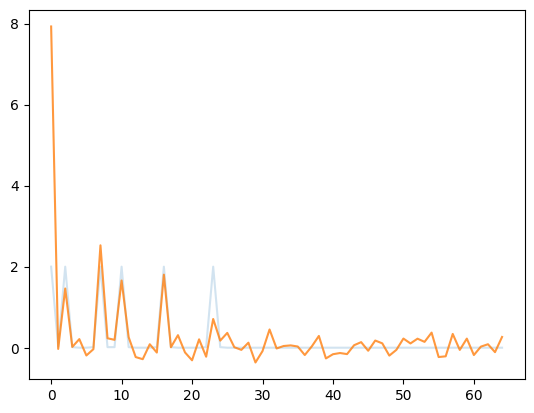

In [14]:

Ms = []
shifts = [] 
for k in range(100):
    evalseq, shift = next(iter(myloader))
    evalseq = evalseq[:, :2].to(mymodel.nftlayers[0].encoder.device)
    predicted = mymodel(evalseq, n_rolls=1)
    shifts.append(shift)
    Ms.append(mymodel.nftlayers[0].dynamics.M) 
    
shifts = torch.concatenate(shifts)
Ms = torch.concatenate(Ms).detach()
print(Ms.shape)

targfreq, prods = ca.inner_prod(Ms.to(shifts.device), shifts, maxfreq=64, bins=65)
deltas = ca.deltafxn(targfreq, mydata.freqsel)*2
plt.plot(targfreq, deltas, label='gt',alpha=0.2)
plt.plot(targfreq, prods, label='pred',alpha=0.8)

torch.Size([2000, 12, 12])


100%|██████████| 65/65 [00:19<00:00,  3.34it/s]


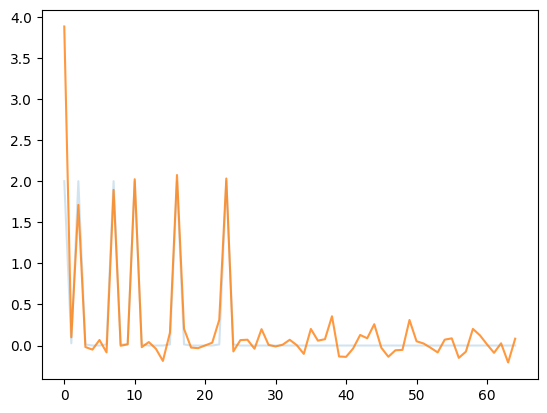

In [15]:
Ms = []
shifts = [] 
for k in range(100):
    evalseq, shift = next(iter(myloader))
    evalseq = evalseq[:, :2].to(mymodel.nftlayers[0].encoder.device)
    predicted = mymodel(evalseq, n_rolls=1)
    shifts.append(shift)
    Ms.append(mymodel.nftlayers[-1].dynamics.M) 
    
shifts = torch.concatenate(shifts)
Ms = torch.concatenate(Ms).detach()
print(Ms.shape)

targfreq, prods = ca.inner_prod(Ms.to(shifts.device), shifts, maxfreq=64, bins=65)
deltas = ca.deltafxn(targfreq, mydata.freqsel)*2
plt.plot(targfreq, deltas, label='gt',alpha=0.2)
plt.plot(targfreq, prods, label='pred',alpha=0.8)

In [16]:

def replace_lowhalf(sqM):
    n, b, b = sqM.shape
    blocksize = b //2 
    zeroblock = torch.zeros(blocksize, blocksize)
    onesblock = torch.ones(blocksize, blocksize)
    maskup = torch.block_diag(onesblock,  zeroblock).to(dtype=sqM.dtype)
    
    sqM = sqM * maskup
    return sqM 

def replace_uphalf(sqM):
    n, b, b = sqM.shape
    blocksize = b //2 
    zeroblock = torch.zeros(blocksize, blocksize)
    onesblock = torch.ones(blocksize, blocksize)
    masklow = torch.block_diag(zeroblock,  onesblock).to(dtype=sqM.dtype)
    
    sqM = sqM * masklow 
    return sqM 

In [17]:
Mup = replace_lowhalf(Ms.to('cpu'))
Mbot = replace_uphalf(Ms.to('cpu'))
Ms.shape

torch.Size([2000, 12, 12])

In [18]:
targfreqUp, prodsUp = ca.inner_prod(Mup.to(shifts.device), shifts, maxfreq=64, bins=65)
targfreqBot, prodsBot = ca.inner_prod(Mbot.to(shifts.device), shifts, maxfreq=64, bins=65)

100%|██████████| 65/65 [00:18<00:00,  3.48it/s]


(array([ 7, 10, 16]),)


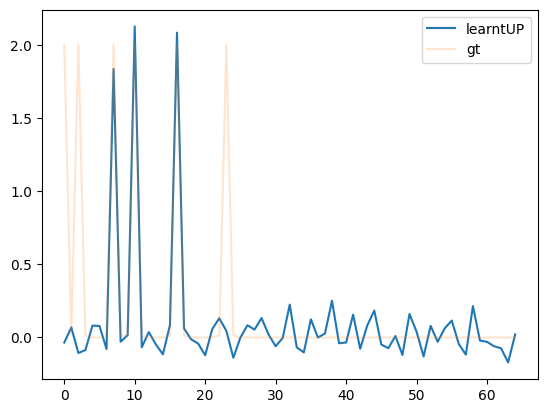

In [22]:
import numpy as np
plt.figure()
plt.plot(targfreqUp, prodsUp, label='learntUP')
deltas = ca.deltafxn(targfreqUp, mydata.freqsel)*2
plt.plot(targfreqUp, deltas, label='gt',alpha=0.2)
plt.legend()
print(np.where(prodsUp > 1) ) 

In [ ]:
plt.figure()
plt.plot(targfreqBot, prodsBot, label='learntBot', alpha=1.0)
#plt.plot(targfreqBot, prodsUp, label='learntUp', alpha=0.6)

deltas = ca.deltafxn(targfreqBot, mydata.freqsel)*2
plt.plot(targfreqBot, deltas, label='gt', alpha=0.2)
print(np.where(prodsBot > 1) ) 
plt.legend()

In [21]:
mymodel.nftlayers[0].encoder.maskmat

Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0',
       dtype=torch.float64)

In [36]:
targfreq

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.])

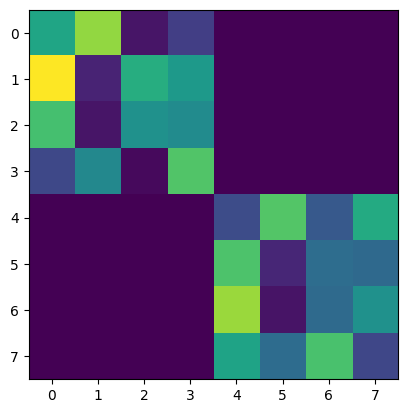

In [12]:
plt.imshow(torch.abs(Ms[0]).detach().to('cpu'))

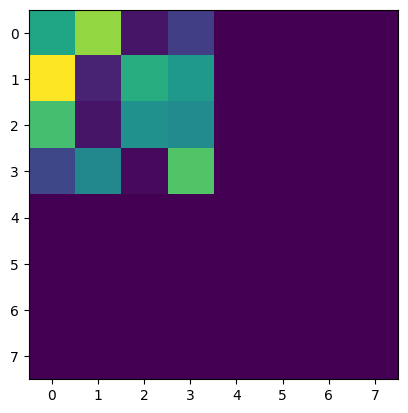

In [13]:
plt.imshow(torch.abs(Mup[0]).detach().to('cpu'))

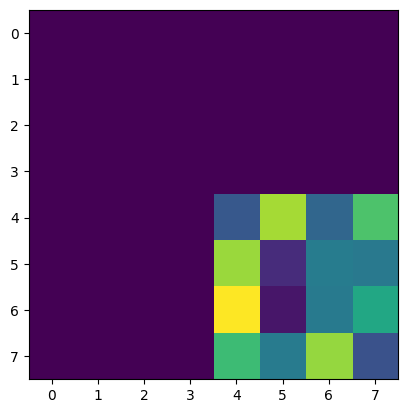

In [14]:
plt.imshow(torch.abs(Mbot[0]).detach().to('cpu'))

In [51]:
mymodel.nftlayers[-1].dynamics.mask

Parameter containing:
tensor([[1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1.]], device='cuda:0',
       dtype=torch.float64)

In [35]:
mymodel.nftlayers[-1].encoder.maskmat

Parameter containing:
tensor([[1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1.]], device='cuda:0',
       dtype=torch.float64)

In [19]:
Ms[0]

tensor([[-0.0518, -0.5851, -0.4031,  0.3487, -0.0778, -0.0203,  0.0000,  0.0000,
          0.0000, -0.0000,  0.0000,  0.0000],
        [ 0.4113,  0.1029,  0.2574,  0.3590,  0.5493, -0.5645,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [-0.1077,  0.8094,  0.0870,  0.6018,  0.4188,  0.6564,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [-0.5313,  0.4085,  0.0983,  0.1017, -0.8708, -0.1923,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0378, -0.1644,  0.0134, -0.3690,  0.2750,  0.1564,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0736,  0.1268, -0.8823, -0.2792,  0.2969, -0.5139,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.8451,  0.3554,
         -0.3543, -0.7699,  0.0633,  0.0188],
        [-0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.1867,  0.8711,
         -0.3497,  0.1063, -0.

In [7]:
48/128

0.375

In [10]:
import numpy as np
128/8 * np.array(range(8))

array([  0.,  16.,  32.,  48.,  64.,  80.,  96., 112.])

In [11]:
128/4 * np.array(range(4))

array([ 0., 32., 64., 96.])